# Volumetrics


This module that generates circuits on a graph which represents the QPU or QVM lattice. The basic idea is it will compute error rates of circuits as a function of depth and width.

The `width` of the circuit is the number of connected vertices on a particular subgraph.

The `depth` is defined in context-dependent way; to avoid confusion with circuit depth we may use the term 'repetitions'.

In [5]:
import random
import itertools
import networkx as nx
import numpy as np
import pandas as pd
import time
# from scipy.spatial.distance import hamming
# import scipy.interpolate

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer, get_benchmarker
from pyquil.gates import CNOT, CCNOT, Z, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest.benchmarking.volumetrics import *

## Get lattice

In [6]:
# if you want to run on a "real lattice"
from pyquil import *
#list_quantum_computers()
#perfect_qc = get_qc("Aspen-1-16Q-A", as_qvm=True, noisy=False)
#noisy_qc = get_qc("Aspen-1-16Q-A") #, as_qvm=True, noisy=True)

noisy_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=True)
perfect_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=False)

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


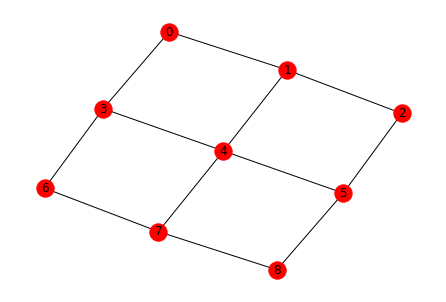

In [7]:
nx.draw(perfect_qc.qubit_topology(),with_labels=True)

In [8]:
G = perfect_qc.qubit_topology()

## Gate sets

### Classical

In [27]:
def two_q_id(qb1,qb2):
    prog = Program()
    prog +=I(qb1)
    prog +=I(qb2)
    return prog

one_c_gates = [X,I]
two_c_gates = [two_q_id, CNOT]
two_c_toffoli = two_c_gates + [CCNOT]

# x basis gates
from forest.benchmarking.classical_logic import CNOT_X_basis, CCNOT_X_basis
one_x_c_gates = [Z, I]
two_x_c_gates = [two_q_id, CNOT_X_basis]
two_x_c_toffoli = two_x_c_gates + [CCNOT_X_basis]
# if you want to do something in the X basis, add Hadamard layers appropriately; see below.

### Some quantum

In [10]:
one_q_gates = [X,Z,I]
two_q_gates = [two_q_id,CZ]

### Random Cliffords

We use a benchmarker for this. Typically we use the native gates from `get_rb_gateset` to implement each clifford.

In [11]:
from forest.benchmarking.randomized_benchmarking import get_rb_gateset

In [12]:
# my config has gone all cattywampus so i need to do this
bm = get_benchmarker()#endpoint='tcp://localhost:6000')

In [13]:
bm.client.endpoint

'tcp://127.0.0.1:5555'

## Get random gates on a graph

In [14]:
prog1 = random_single_qubit_gates(G, one_q_gates)
prog2 = random_two_qubit_gates(G, two_q_gates)
print(prog1+prog2)

X 0
Z 1
X 2
Z 3
I 4
X 5
Z 6
Z 7
X 8
CZ 0 3
CZ 0 1
CZ 1 4
I 1
I 2
I 2
I 5
CZ 3 6
CZ 3 4
I 4
I 7
I 4
I 5
CZ 5 8
I 6
I 7
CZ 7 8



In [15]:
progy = random_single_qubit_cliffords(bm, G)
print(progy)

RX(-pi/2) 0
RZ(pi/2) 0
RZ(-pi/2) 1
RX(-pi) 1
RZ(-pi) 2
RZ(-pi) 2
RX(-pi/2) 3
RZ(-pi/2) 3
RZ(-pi/2) 4
RZ(pi/2) 5
RZ(pi/2) 6
RX(-pi/2) 6
RX(pi/2) 7
RZ(-pi/2) 7
RX(pi/2) 8
RZ(-pi) 8



## Make some circuit templates and sample programs from them


In [16]:
classical_1q_layer = get_rand_1q_template(one_c_gates)
print(classical_1q_layer.sample_program(G, repetitions=2, width=2))

X 3
I 6
I 3
I 6



In [17]:
classical_2q_layer = get_rand_2q_template(two_c_gates)
print(classical_2q_layer.sample_program(G, repetitions=2, width=2))

I 4
I 7
CNOT 4 7



In [21]:
switch_basis_layer = get_switch_basis_x_z_template()
print(switch_basis_layer.sample_program(G, repetitions=1, width=4))

H 2
H 5
H 7
H 8



In [22]:
clifford_1q_layer = get_rand_1q_cliff_template(bm)
clifford_2q_layer = get_rand_2q_cliff_template(bm)
print(clifford_2q_layer.sample_program(G, repetitions=2, width=2))

CZ 3 4
RZ(pi/2) 4
RX(-pi/2) 3
CZ 3 4
RX(pi/2) 4
RZ(-pi/2) 3
RX(-pi/2) 3
CZ 3 4
RZ(pi/2) 4
RX(-pi/2) 4



In [23]:
rand_perm_layer = get_rand_qubit_perm_template()
# sometimes this returns an empty program, i.e. no permutation
print(rand_perm_layer.sample_program(G, 1, qc=noisy_qc, width=3))

RZ(-3.11559416083055) 2
RX(pi/2) 2
RZ(0.9985930931695964) 2
RX(-pi/2) 2
RZ(0.33645965947699885) 5
RX(pi/2) 5
RZ(1.1143132339260913) 5
RX(-pi/2) 5
CZ 5 2
RZ(1.8502545221336462) 2
RX(pi/2) 2
RZ(-1.493206408133509) 5
RX(-pi/2) 5
CZ 5 2
RX(-pi/2) 2
RX(pi/2) 5
CZ 5 2
RZ(1.7273460464564303) 2
RX(pi/2) 2
RZ(0.4625719031986815) 2
RX(-pi/2) 2
RZ(-0.5110412432518459) 2
RZ(-1.166166861993211) 5
RX(pi/2) 5
RZ(0.6298859814840272) 5
RX(-pi/2) 5
RZ(2.6282638093266915) 5



In [24]:
rand_su4_layer = get_rand_su4_template()
print(rand_su4_layer.sample_program(G, 1, qc=noisy_qc, width=2))

RZ(-1.2990942230030267) 4
RX(pi/2) 4
RZ(1.5155074169065497) 4
RX(-pi/2) 4
RZ(1.7430125039887816) 5
RX(pi/2) 5
RZ(1.4191531043790895) 5
RX(-pi/2) 5
CZ 5 4
RZ(-1.2516854599739062) 4
RX(pi/2) 4
RZ(2.110642864158322) 4
RX(-pi/2) 4
RZ(-2.8531720822941167) 5
RX(-pi/2) 5
CZ 5 4
RX(pi/2) 4
RZ(-2.0269992194907793) 4
RX(-pi/2) 4
RZ(1.7707585610544267) 5
RX(pi/2) 5
CZ 5 4
RZ(-2.7752501314248956) 4
RX(pi/2) 4
RZ(0.6563900562878288) 4
RX(-pi/2) 4
RZ(2.3643866667806357) 4
RZ(-2.2772139390064376) 5
RX(pi/2) 5
RZ(1.8032677495210245) 5
RX(-pi/2) 5
RZ(-2.022168105894388) 5



## Compose templates

In [25]:
classical_1q_2q = classical_1q_layer + classical_2q_layer
print(classical_1q_2q.sample_program(G, repetitions=2, width=4))

X 1
X 3
I 4
X 7
I 1
I 4
CNOT 3 4
CNOT 4 7
I 1
X 3
I 4
I 7
I 1
I 4
I 3
I 4
I 4
I 7



Classical Logic in X basis

In [33]:
logic_layers = get_rand_1q_template(one_x_c_gates) + get_rand_2q_template(two_x_c_gates)
classical_x_1q_2q = switch_basis_layer + logic_layers + switch_basis_layer
# here we demonstrate a simple use of a pattern. We want to do the basis switch at beginning and end 
# while doing the repetitions in between some variable number of times.
# The pattern says to do the 0 idx generator, do [1,2] idx generators n times, then finish with 3 idx generator
classical_x_1q_2q.pattern = [0, ([1, 2], 'n'), 3]
print(classical_x_1q_2q.sample_program(G, repetitions=3, width=2))
# note that the x basis CNOT(0, 1) is H(0) CZ(0, 1) H(0)

H 5
H 8
Z 5
I 8
I 5
I 8
I 5
I 8
I 5
I 8
I 5
I 8
H 5
CZ 5 8
H 5
H 5
H 8



In [34]:
clifford_sandwich = clifford_1q_layer + clifford_2q_layer + get_dagger_all_template()
# here we demonstrate another simple use of a pattern. We want to do some Clifford layers n=reps
# number of times and then dagger the result of all those reps. 
clifford_sandwich.pattern = [([0, 1], 'n'), -1]
prog = clifford_sandwich.sample_program(G, repetitions=3, width=2,  qc=noisy_qc)
print(prog)

# We can check that this is the identity by compiling it fully
print("This program compiles away to nothing: ")
print(noisy_qc.compiler.quil_to_native_quil(prog))

RX(-pi/2) 3
RX(pi/2) 4
RZ(-pi) 4
RX(pi/2) 3
CZ 3 4
RX(-pi/2) 4
RZ(-pi/2) 3
RX(pi/2) 3
RZ(-pi/2) 3
RX(-pi/2) 3
RX(pi/2) 4
RZ(-pi) 4
RX(pi/2) 3
CZ 3 4
RX(pi/2) 4
CZ 3 4
RZ(-pi/2) 4
RZ(-pi/2) 3
RZ(pi/2) 3
RX(-pi) 3
RX(pi/2) 4
RX(-pi/2) 4
CZ 3 4
RZ(-pi/2) 4
RX(pi/2) 4
RX(-pi/2) 3
CZ 3 4
RX(-pi/2) 4
RX(-pi/2) 3
RZ(pi/2) 3
RX(pi/2) 3
RZ(pi/2) 3
RZ(-pi/2) 4
RX(pi/2) 4
RZ(-pi/2) 4

This program compiles away to nothing: 
HALT



### Quantum Volume (unoptimized)

In [35]:
qv_template = rand_perm_layer + rand_su4_layer
print(qv_template.sample_program(G, repetitions=2, qc=noisy_qc, width=5))

RZ(-pi/2) 3
RX(pi/2) 3
CZ 0 3
RZ(0.6669073931670509) 4
RX(pi/2) 4
RZ(0.5854615772794022) 4
RX(-pi/2) 4
RZ(-3.06066309923684) 4
RZ(-pi/2) 0
RX(pi/2) 0
RZ(2.4107959821067877) 0
RX(-pi/2) 0
RZ(-0.5585293438296013) 1
RX(pi/2) 1
CZ 0 1
RX(pi/2) 0
RZ(pi) 1
RX(pi/2) 1
CZ 0 1
RZ(pi/2) 3
RZ(pi) 0
RX(pi/2) 0
CZ 3 0
RZ(-2.4305289034535735) 1
RX(pi/2) 1
RZ(0.4608188356599866) 1
RX(-pi/2) 1
RZ(2.740126082031923) 4
RX(pi/2) 4
RZ(1.1064691618894351) 4
RX(-pi/2) 4
CZ 4 1
RZ(1.3016838095222525) 1
RX(pi/2) 1
RZ(-1.5895747244078953) 4
RX(-pi/2) 4
CZ 4 1
RX(-pi/2) 1
RX(pi/2) 4
CZ 4 1
RX(pi/2) 3
RZ(-0.31660508427036405) 4
RX(pi/2) 4
RZ(1.9412910023569236) 4
RX(-pi/2) 4
CZ 3 4
RX(-pi/2) 3
CZ 3 0
RZ(0.25293664903812485) 4
RX(pi/2) 4
CZ 4 3
RZ(-2.583063309760192) 0
RZ(-0.46129210523277475) 1
RX(pi/2) 1
RZ(0.2166354441029604) 1
RX(-pi/2) 1
RZ(1.6427579756968358) 1
RX(pi/2) 3
RZ(-pi/2) 3
RZ(-pi/2) 4
RX(-pi/2) 4
RZ(0.7757916810497658) 0
RX(pi/2) 0
RZ(2.031126351623488) 0
RX(-pi/2) 0
RZ(1.8194447794701258) 1
RX(p

## Acquire data for ranges of (width, depth)

In [36]:
widths = [2, 3, 4]
depths = [3, 4]
ckt = classical_1q_2q
prog_array = generate_volumetric_program_array(noisy_qc, ckt, widths, depths, num_circuit_samples=10)
print(prog_array)

{2: {4: [<pyquil.quil.Program object at 0x7fd27c50f908>, <pyquil.quil.Program object at 0x7fd27c513208>, <pyquil.quil.Program object at 0x7fd27c513978>, <pyquil.quil.Program object at 0x7fd27c5087b8>, <pyquil.quil.Program object at 0x7fd27c519470>, <pyquil.quil.Program object at 0x7fd27c519e48>, <pyquil.quil.Program object at 0x7fd27c49c9b0>, <pyquil.quil.Program object at 0x7fd27c4a3278>, <pyquil.quil.Program object at 0x7fd27c519dd8>, <pyquil.quil.Program object at 0x7fd27c4a3a20>]}, 3: {4: [<pyquil.quil.Program object at 0x7fd27c4a79e8>, <pyquil.quil.Program object at 0x7fd27c4ab9b0>, <pyquil.quil.Program object at 0x7fd27c4abdd8>, <pyquil.quil.Program object at 0x7fd27c4acc50>, <pyquil.quil.Program object at 0x7fd27c4b6c50>, <pyquil.quil.Program object at 0x7fd27c4bc470>, <pyquil.quil.Program object at 0x7fd27c4bf470>, <pyquil.quil.Program object at 0x7fd27c4c30f0>, <pyquil.quil.Program object at 0x7fd27c4c3b38>, <pyquil.quil.Program object at 0x7fd27c4c9898>]}, 4: {4: [<pyquil.qui

In [37]:
noisy_results = acquire_volumetric_data(noisy_qc, prog_array)

In [38]:
ideal_results = acquire_volumetric_data(perfect_qc, prog_array, num_shots=1)
print(ideal_results)

{2: {4: [array([[0, 1]]), array([[0, 1]]), array([[1, 0]]), array([[0, 0]]), array([[1, 0]]), array([[1, 1]]), array([[0, 0]]), array([[0, 0]]), array([[1, 0]]), array([[0, 0]])]}, 3: {4: [array([[1, 1, 0]]), array([[0, 0, 0]]), array([[1, 1, 1]]), array([[1, 0, 1]]), array([[1, 0, 0]]), array([[0, 1, 0]]), array([[1, 0, 1]]), array([[1, 1, 0]]), array([[1, 0, 0]]), array([[0, 1, 0]])]}, 4: {4: [array([[1, 0, 0, 0]]), array([[0, 0, 1, 1]]), array([[0, 0, 1, 0]]), array([[0, 1, 1, 0]]), array([[0, 0, 1, 1]]), array([[0, 1, 1, 1]]), array([[0, 0, 1, 0]]), array([[1, 0, 0, 0]]), array([[1, 1, 0, 0]]), array([[1, 0, 1, 1]])]}}


In [39]:
err_hamm_distrs = get_error_hamming_weight_distributions(noisy_results, ideal_results)
print(err_hamm_distrs)

{2: {4: [array([0.888, 0.112, 0.   ]), array([0.852, 0.148, 0.   ]), array([0.882, 0.112, 0.006]), array([0.94, 0.06, 0.  ]), array([0.904, 0.094, 0.002]), array([0.828, 0.162, 0.01 ]), array([0.946, 0.054, 0.   ]), array([0.934, 0.066, 0.   ]), array([0.862, 0.138, 0.   ]), array([0.958, 0.042, 0.   ])]}, 3: {4: [array([0.828, 0.154, 0.018, 0.   ]), array([0.91, 0.08, 0.01, 0.  ]), array([0.738, 0.23 , 0.032, 0.   ]), array([0.776, 0.202, 0.02 , 0.002]), array([0.868, 0.114, 0.018, 0.   ]), array([0.858, 0.136, 0.006, 0.   ]), array([0.802, 0.182, 0.016, 0.   ]), array([0.79 , 0.194, 0.014, 0.002]), array([0.848, 0.128, 0.018, 0.006]), array([0.828, 0.164, 0.006, 0.002])]}, 4: {4: [array([0.88 , 0.112, 0.008, 0.   , 0.   ]), array([0.772, 0.21 , 0.014, 0.004, 0.   ]), array([0.832, 0.158, 0.01 , 0.   , 0.   ]), array([0.778, 0.196, 0.022, 0.002, 0.002]), array([0.782, 0.196, 0.02 , 0.002, 0.   ]), array([0.708, 0.244, 0.034, 0.014, 0.   ]), array([0.802, 0.182, 0.014, 0.002, 0.   ]), 

In [40]:
avg_err_hamm_distrs = {w: {d: sum(distrs)/len(distrs)} for w, d_arr in err_hamm_distrs.items()
                            for d, distrs in d_arr.items()}
print(avg_err_hamm_distrs)

{2: {4: array([0.8994, 0.0988, 0.0018])}, 3: {4: array([0.8246, 0.1584, 0.0158, 0.0012])}, 4: {4: array([7.92e-01, 1.85e-01, 1.98e-02, 3.00e-03, 2.00e-04])}}


## Plot a particular depth and width

In [ ]:
dep = 6
wid = 4

distz = get_hamming_dist(res_df, dep, wid)


# combine data from different subgraphs
avg_dist = distz['Hamming dist. data'].mean()

# rand data
rand_dist = distz['Hamming dist. rand'][0]

In [ ]:
x_labels = np.arange(0, len(avg_dist))
plt.bar(x_labels, avg_dist, width=0.61, align='center')
plt.bar(x_labels, rand_dist, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.ylim([0,1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.show()

# For a particular width plot all depths

In [ ]:
wid = 4
df_fn_depth = get_hamming_dists_fn_depth(res_df, wid)

In [ ]:
for dep in range(1, df_fn_depth.Depth.max()+1):
    idx = df_fn_depth['Depth']== dep
    avg_dist = df_fn_depth[idx]['Hamming dist. data'].mean() 
    rand_dist = df_fn_depth[idx]['Hamming dist. rand'].mean() 
    x_labels = np.arange(0, len(avg_dist))
    plt.subplot(1,df_fn_depth.Depth.max(),dep)
    plt.bar(x_labels, avg_dist, width=0.61, align='center')
    plt.bar(x_labels, rand_dist, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data fron the data frame.

In [ ]:
depth_vec = []
pcheck = []
pcheck_rand = []
pcheck_log_errors = []
pcheck_log_errors_rand = []
tvd_rand = []
tvd_ideal = []

for dep in range(1, df_fn_depth.Depth.max()+1):
    idx = df_fn_depth['Depth']== dep
    depth_vec.append(dep)
    pcheck.append(df_fn_depth[idx]['Pr. success data'].mean()) 
    pcheck_rand.append(df_fn_depth[idx]['Pr. success rand'].mean())
    pcheck_log_errors.append(df_fn_depth[idx]['Pr. success loge data'].mean())
    pcheck_log_errors_rand.append(df_fn_depth[idx]['Pr. success loge rand'].mean())
    tvd_ideal.append(df_fn_depth[idx]['TVD(data, ideal)'].mean())
    tvd_rand.append(df_fn_depth[idx]['TVD(data, rand)'].mean())

# Success probablity and success probablity including a small number of errors

Next we will plot the success probablity of a circuit with a certain width as a function of depth. 

In [ ]:
plt.scatter(depth_vec,pcheck,label='Sucess Probablity')
plt.plot(depth_vec,pcheck_rand,label='random guess')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(wid))
plt.legend()
plt.show()

**Sucess if we allow for a small number of errors**

Some near term algorithms have robustness to noise. In light of that we might want to consider answers that are only a little wrong successes.

To make this notion formal we allow a logarithmic number of bits to flip from the correct answer and call all such instances "success".

The logarithmic number of bits that we allow to flip is defined by the "basement" ${\mathcal B}$ of 

$\log_2 ({\rm number\ of\ bits}) -1$

where the basement of a number is ${\mathcal B}(number) = 0$ if number$<=0$ and ${\mathcal B}(number) = {\rm floor (number)}$.


Supose we have a circuit of width 4, this means correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4)-1 = 1$.

So any string with hamming weight zero or one counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

In [ ]:
plt.figure()
plt.scatter(depth_vec,pcheck,label='Sucess Probablity')
plt.plot(depth_vec,pcheck_rand,label='random guess')
plt.scatter(depth_vec,pcheck_log_errors,label='Sucess Probablity + log errors')
plt.plot(depth_vec,pcheck_log_errors_rand,label='random guess + log errors')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success+log errors)')
plt.title('Pr(success+log errors) vs Depth for Width = {}'.format(wid))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

## Total variation distance from ideal answer and random distribution

In [ ]:
plt.figure()
plt.scatter(depth_vec,tvd_ideal,label='TVD(data, ideal)')
plt.scatter(depth_vec,tvd_rand,label='TVD(data, rand)')
plt.scatter(depth_vec,1-np.asarray(pcheck),label='1-Sucess Probablity',alpha=0.33,marker='^',s=80)
#plt.plot(depth_vec,pcheck_log_errors_rand,label='random guess + log errors')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.ylabel('Total variation distance')
plt.title('Width = {}'.format(wid))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Plot depth = width

In [ ]:
max_idx = min([max(res_df['Depth']),max(res_df['Width'])])

for idx in range(1,max_idx+1):
    distz = get_hamming_dist(res_df, idx, idx)
    # combine data from different subgraphs
    avg_dist = distz['Hamming dist. data'].mean()
    # rand data
    rand_dist = distz['Hamming dist. rand'][0]
    dep = idx
    wid = idx
    x_labels = np.arange(0, len(avg_dist))
    plt.subplot(1,max_idx,idx)
    plt.bar(x_labels, avg_dist, width=0.61, align='center')
    plt.bar(x_labels, rand_dist, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

## Plot the distribution of sublattice widths

[9, 12, 22, 36, 49, 48, 32, 9, 1, 9, 12, 22, 36, 49, 48, 32, 9, 1]

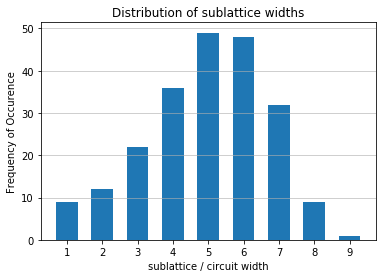

In [65]:
G = perfect_qc.qubit_topology()
len(perfect_qc.qubit_topology())
# distribution of graph lengths
distr = []
for num_nodes in range(1, len(G.nodes) + 1):
    listg = generate_connected_subgraphs(G, num_nodes)
    distr.append(len(listg))

cir_wid = list(range(1, len(G.nodes) + 1))
plt.bar(cir_wid, distr, width=0.61, align='center')
plt.xticks(cir_wid)
plt.xlabel('sublattice / circuit width')
plt.ylabel('Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of sublattice widths')
disty

# Plot success probablity landscape

This is just the success probablity as a function of depth and width.

In [ ]:
values = np.asarray([munged['Pr. success data'][idx] for idx in munged.index])
values

In [ ]:
values_rand = np.asarray([munged['Pr. success rand'][idx] for idx in munged.index])
values_rand

In [ ]:
x = np.arange(min(res_df['Depth']), max(res_df['Depth'])+1)

y = np.arange(min(res_df['Width']), max(res_df['Width'])+1)

X, Y = np.meshgrid(x, y)

In [ ]:
(x1,x2) = X.shape
Zdata = np.reshape(values,(x2,x1)).T
Zrand = np.reshape(values_rand,(x2,x1)).T

In [ ]:
Zdata

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability')
plt.show()

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zrand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
tvd_rand_values = np.asarray([munged['TVD(data, rand)'][idx] for idx in munged.index])
tvd_ideal_values = np.asarray([munged['TVD(data, ideal)'][idx] for idx in munged.index])
Ztvd_rand = np.reshape(tvd_rand_values,(x2,x1)).T
Ztvd_ideal = np.reshape(tvd_ideal_values,(x2,x1)).T

In [ ]:
tvd_ideal_values
tvd_rand_values

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Ztvd_ideal, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Ztvd_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
loge_rand_values = np.asarray([munged['Pr. success loge rand'][idx] for idx in munged.index])
loge_data_values = np.asarray([munged['Pr. success loge data'][idx] for idx in munged.index])
Zlge_rand = np.reshape(loge_rand_values,(x2,x1)).T
Zlge_data = np.reshape(loge_data_values,(x2,x1)).T

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zlge_data, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zlge_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

# Data exploration

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
size = Y.shape
width_1d = Y.reshape((1,np.prod(size)))
depth_1d = X.reshape((1,np.prod(size)))

In [ ]:
data_1d = Zdata.reshape((1,np.prod(size)))
data_1d.shape
width_1d.shape


In [ ]:
dims = np.zeros_like(width_1d)
dims[0,0] = size[0]
dims[0,1] = size[1]

xdata = np.vstack((dims,width_1d, depth_1d))



xdata

## Fitting models

Two parameter model 


$f(W,D,p_W,p_D) =  (1-p_W)^W * (1-p_D)^D $

The fidelity is proporional to $1 - p$

In [ ]:
def two_param(x,pw,pd):
    temp = x[0]
    wid = temp[0]
    dep = temp[1]
    width = x[1].reshape(wid,dep)
    depth = x[2].reshape(wid,dep)
    pcheck = (1-pw)**(width) * (1-pd)**depth
    rpcheck = pcheck.reshape((1,wid*dep))
    return rpcheck.ravel()

One parameter model

$f(W,D,p) =  (1-p)^{W * D} $

In [ ]:
def one_param(x,p):
    temp = x[0]
    wid = temp[0]
    dep = temp[1]
    width = x[1].reshape(wid,dep)
    depth = x[2].reshape(wid,dep)
    pcheck = (1-p)**(width*depth)
    rpcheck = pcheck.reshape((1,wid*dep))
    return rpcheck.ravel()

From my prior work a better model to fit to is

Pcheck$(W,D,p,a,b,c) = \exp[ -(a p^2 + b p + c)* W*D] $


In [ ]:
def two_param_exp(x,p,a,b):
    temp = x[0]
    wid = temp[0]
    dep = temp[1]
    width = x[1].reshape(wid,dep)
    depth = x[2].reshape(wid,dep)
    pcheck = np.exp(-(a*p + b) * width * depth)
    rpcheck = pcheck.reshape((1,wid*dep))
    return rpcheck.ravel()

**Start with one paramter model**

In [ ]:
pguess = 0.1
popt, pcov = curve_fit(one_param, xdata, data_1d.ravel(), p0=pguess, bounds=(0, 1))

In [ ]:
print('The estimated error is p = ', str(np.round(popt[0],4)))
print('The estimated product of the one and two qubit fidelity is F = ', str(1-np.round(popt[0],4)))
#print('The one standard deviation on the estimate is ', str(np.round(np.sqrt(np.diag(pcov)[0]),5)))

In [ ]:
zfit = one_param(xdata,popt)
Z_fit = zfit.reshape(size)

In [ ]:
plt.pcolormesh(X,Y, Z_fit)
plt.xticks(list(range(1,circuit_depth+1)))
plt.yticks(list(range(1,circuit_width+1)))
plt.colorbar()
plt.show()

In [ ]:
plt.pcolormesh(X,Y,Zdata)
plt.xticks(list(range(1,circuit_depth+1)))
plt.yticks(list(range(1,circuit_width+1)))
plt.colorbar()
plt.show()

**Two parameter model**

In [ ]:
pguess2d = [0.0276, 0.01, 0.4]

In [ ]:
popt2d, pcov2d = curve_fit(two_param_exp, xdata, data_1d.ravel(), p0=pguess2d , bounds=(0., 1))

In [ ]:
popt2d

In [ ]:
zfit2d = two_param(xdata,popt2d[0],popt2d[1])
Z_fit2d = zfit2d.reshape(size)

In [ ]:
plt.pcolormesh(X,Y, Z_fit2d)
plt.xticks(list(range(1,circuit_depth+1)))
plt.yticks(list(range(1,circuit_width+1)))
plt.colorbar()
plt.show()

In [ ]:
1-1.02319786e-01